# DCGAN on MNIST Digits dataset

Following the original GAN [1], Deep Convolutional Generative Adversarial Network (DCGAN) [2] is replacing some of the layers with convolutional layers.

The result is similar but taking advantage of the properties of the convolutional layers: less parameters to train, space invariance.

## Learning goals

- Starting from the GAN implementation notebook ([HTML](MNIST_GAN.html) / [Jupyter](MNIST_GAN.ipynb)), use convolutional layers


In [ ]:
COLAB = True

if COLAB:
  from google.colab import drive
  drive.mount('/content/drive')

In [ ]:
!pip install tensorview

In [3]:
import sys
import tensorflow as tf
import plotly.graph_objects as go
from ipywidgets import widgets
import numpy as np
from tensorflow.keras import models, layers, losses, optimizers, metrics
import tensorflow_datasets as tf_ds
import tensorview as tv
import matplotlib.pyplot as plt
from pathlib import Path

In [4]:
if COLAB:
  model_path = Path('/content/drive/My Drive/Colab Notebooks/DsStepByStep')
else:
  model_path = Path('model')

In [5]:
batch_size = 100
latent_dim = 100
# Padding to 32x32 for better filtering by convo
image_width, image_height, image_channels = 32, 32, 1 
mnist_dim = image_width * image_height * image_channels

In [6]:
disc_learning_rate = 0.0002
gen_learning_rate  = 0.0002

relu_alpha = 0.01

# Data

MNIST dataset is optimized to be stored efficiently: images are closely cropped at 28x28 pixels and stored as 1 byte per pixel (uint8 format). However, to get proper performance we need to modify the input data to insert some padding around and convert the pixel format to float on 32 bits.

In [7]:
def normalize_img(image, label):
  """Normalizes images: `uint8` -> `float32` and pad to 32 x 32"""
  image_float = tf.cast(image, tf.float32)/ 128. - 1.
  image_padded = tf.pad(image_float, [[0, 0], [2, 2], [2, 2], [0, 0]])
  return image_padded, label

(ds_train, ds_test) = tf_ds.load('mnist', split=['train', 'test'], batch_size=batch_size, as_supervised=True)
ds_train = ds_train.map(normalize_img)
#ds_train.batch(batch_size)
ds_train = ds_train.cache()

ds_test = ds_test.map(normalize_img)
#ds_test = ds_test.batch(batch_size)
ds_test = ds_test.cache()

ds_train, ds_test

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead set
data_dir=gs://tfds-data/datasets.





Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.0. Subsequent calls will reuse this data.


(<DatasetV1Adapter shapes: ((None, 32, 32, 1), (None,)), types: (tf.float32, tf.int64)>,
 <DatasetV1Adapter shapes: ((None, 32, 32, 1), (None,)), types: (tf.float32, tf.int64)>)

# Models

GAN model is built out of a generator and a discriminator:
- The generator gets as input some random noise on space of 100 dimensions, and issues an image (32x32 pixel raster)
- The discriminator is trained to distinguish generated images by the generator (i.e. _fakes_), and reference images from the MNIST

The generator and discriminator architecture are more or less symmetrical. The generator is increasing the output space dimension step by step using upsampling layers after convolutional layers. The discriminator is similar to other classification networks reducing the input space dimensions down to the binary classification layer using strides on the convolutional layer. An alternative implementation of the generator is based on the transpose convolution whose stride is able to upsample.

The "game" is to jointly train the generator and discriminator in order to have the best generator but still being able to detect generated images.

In [8]:
generator = models.Sequential([
    layers.Dense(128 * 8 * 8, input_dim=latent_dim, name='g_1'),
    layers.LeakyReLU(relu_alpha),
    layers.Reshape((8, 8, 128)),
    layers.BatchNormalization(),
    layers.UpSampling2D((2, 2)),
    layers.Dropout(0.3),
    layers.Conv2D(64, kernel_size=(5, 5), padding="same", name='g_c1'),
    layers.LeakyReLU(relu_alpha),
    layers.BatchNormalization(),
    layers.UpSampling2D((2, 2)),
    layers.Conv2D(1, kernel_size=(5, 5), padding="same", activation='tanh', name='g_c2')
], name='generator')

In [9]:
discriminator = models.Sequential([
    layers.Conv2D(8, kernel_size=(5, 5), strides=(2, 2), padding="same", 
                  name='d_c1', input_shape=[32, 32, 1]),
    layers.LeakyReLU(relu_alpha),
    layers.Dropout(0.3),
    layers.Conv2D(64, kernel_size=(5, 5), strides=(2, 2), padding="same", name='d_c2'),
    layers.LeakyReLU(relu_alpha),
    layers.Flatten(),
    layers.Dense(1, activation='sigmoid', name='d_1')
], name='discriminator')

# Training

Training is alternatively on the distriminator and generator.

The discriminator is trained on a batch made of half genuine images and half trained images.

The generator is trained with its output fed into the discriminator (whose wheights are frozen in this phase).

GAN reputation as difficult to be trained is well deserved and originates in the joint optimization which is similar to a minimax problem (min discrination error, max fidelity of the fakes). As seen below, the noise on the losses and accuracies is high. The main facilitators helping this training are:
- Use of leaky ReLU activations to avoid gradient vanishing
- Small learning rate to decrease the noise and instability
- Batch normalization layers to reduce variance at layer inputs

These are actually the recommendations of the DCGAN paper.


In [10]:
discriminator.compile(optimizer=optimizers.Adam(disc_learning_rate),
                loss=losses.binary_crossentropy,
                metrics=['accuracy'])
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
d_c1 (Conv2D)                (None, 16, 16, 8)         208       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 16, 16, 8)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 8)         0         
_________________________________________________________________
d_c2 (Conv2D)                (None, 8, 8, 64)          12864     
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 8, 8, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 4096)              0         
_________________________________________________________________
d_1 (Dense)                  (None, 1)               

Due to the use of convolutional layers, and the small images at input, the number of trainable parameters of the discriminator is low. The number of parameters ot the generator is not that low since the dense layer is connected to all 100 inputs.

In [11]:
# Stack the generator and discriminator in order to train the generator
# Do not train the discriminator along with the generator
discriminator.trainable = False 
combined = models.Sequential([generator, discriminator])
combined.compile(optimizer=optimizers.Adam(gen_learning_rate),
              loss=losses.binary_crossentropy,
              metrics=['accuracy'])
combined.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
generator (Sequential)       (None, 32, 32, 1)         1034625   
_________________________________________________________________
discriminator (Sequential)   (None, 1)                 17169     
Total params: 1,051,794
Trainable params: 1,034,241
Non-trainable params: 17,553
_________________________________________________________________


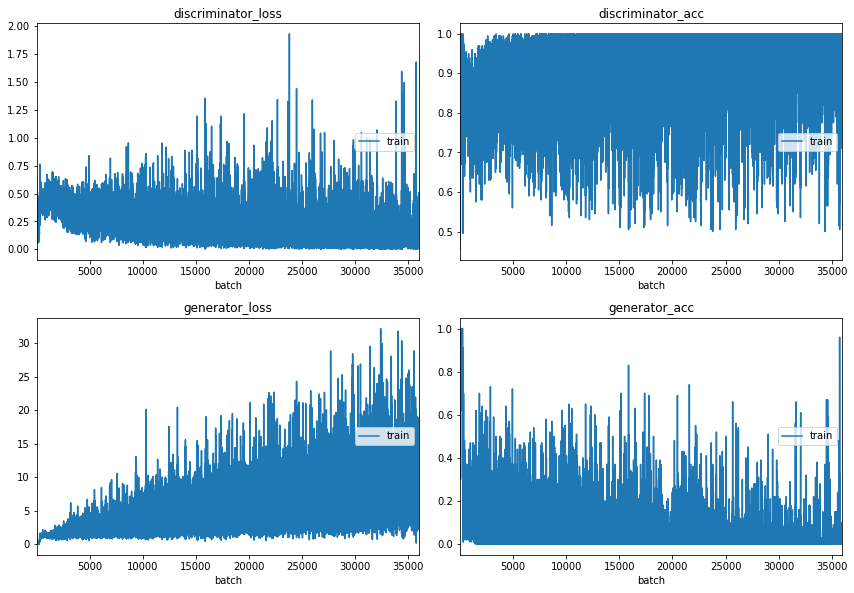

In [12]:
epochs = 60

batch_per_epoch = 60000/batch_size

# Adversarial ground truths
valid = np.ones((batch_size, 1))
fake = np.zeros((batch_size, 1))

tv_plot = tv.train.PlotMetrics(wait_num=50, columns=2, iter_num=epochs * batch_per_epoch)

for epoch in range(epochs):

    for train_batch in iter(ds_train):
    
        imgs = train_batch[0]

        # Discriminator

        # Sample noise and generate a batch of new images
        gen_latent = np.random.normal(0, 1, (batch_size, latent_dim))
        gen_imgs = generator.predict(gen_latent)

        # Train the discriminator (real classified as true and generated as false)
        d_loss, d_acc = discriminator.train_on_batch(np.vstack((imgs, gen_imgs)), 
                                                          np.vstack((valid, fake)), 
                                                          reset_metrics=True)
        
        # Generator

        # Train the generator (wants discriminator to mistake images as true)
        g_loss, g_acc = combined.train_on_batch(gen_latent, 
                                                 valid, 
                                                 reset_metrics=True)
    
        # Plot
        tv_plot.update({'discriminator_loss': d_loss, 'discriminator_acc': d_acc,
                        'generator_loss': g_loss, 'generator_acc': g_acc})
        tv_plot.draw()

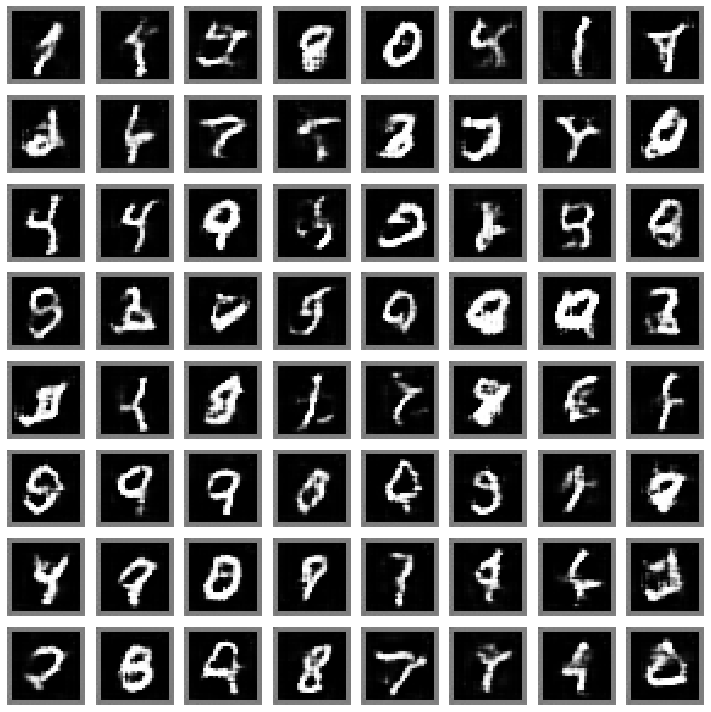

In [13]:
fig, axes = plt.subplots(8, 8, sharex=True, sharey=True, figsize=(10, 10))
for img, ax in zip(gen_imgs, axes.ravel()): # imgs.numpy()
    ax.imshow(img.reshape(image_width, image_height), interpolation='nearest', cmap='gray')
    ax.axis('off')
fig.tight_layout()

In [14]:
combined.save(model_path / 'mnist_dcgan_combined.h5')
discriminator.save(model_path / 'mnist_dcgan_discriminator.h5')
discriminator.save(model_path / 'mnist_dcgan_generator.h5')

# Conclusion

Compared to the original GAN implementation, the disriminator accuracy is not sticking above 90%. The generator seems more able to create convincing fakes. But also the variance on the metrics is high. Visually, there is less noise on the background, digits are rounder. The straight digits like 7 and 1 seems harder to generate to this mode. And there are still some "ghosts" around the main shape.

## Where to go from here

- The original GAN based on dense layers ([HTML](MNIST_GAN.html) / [Jupyter](MNIST_GAN.ipynb))
- Revisit the fundamentals about deep neural networks in the CNN versus Dense classification ([HTML](../cnn/CnnVsDense-Part1.html) / [Jupyter](../cnn/CnnVsDense-Part1.jupyter) )

## References

1. ["Generative adversarial nets"](http://papers.nips.cc/paper/5423-generative-adversarial-nets.pdf), I. Goodfellow, J. Pouget-Abadie, M. Mirza, B. Xu, D. Warde-Farley, S. Ozair, A. Courville, Y. Bengio, NIPS 2014
2. ["Unsupervised representation learning with deep convolutional generative adversarial networks"](https://arxiv.org/pdf/1511.06434.pdf), A. Radford, L. Metz, S. Chintala,
ICLR 2016